## Aperture of a TNG50-1 galaxy

This script shows the different sizes of a subhalo when varying the radius. Different recommendations may be found depending on the author: the half mass radious of dark matter, gas or stars. Depending on your needs, is the aperture you're defining. In my case, I'm analizing the half mass radious of gas and stars.

In [1]:
import h5py
import requests
import matplotlib.pyplot as plt
import numpy as np

This function lets you access to TNG50 data from your account. Your API-key is needed.

In [2]:
#function to access TNG50
def get(path, params=None):
    # make HTTP GET request to path
    headers = {"api-key":"YOUR KEY"}
    r = requests.get(path, params=params, headers=headers)
    
    # raise exception if response code is not HTTP SUCCESS (200)
    r.raise_for_status()
    
    if r.headers['content-type'] == 'application/json':
        return r.json() # parse json responses automatically
    
    if 'content-disposition' in r.headers:
        filename = r.headers['content-disposition'].split("filename=")[1]
        with open(filename, 'wb') as f:
            f.write(r.content)
        return filename # return the filename string
    
    return r

In [3]:
#The subhalo and redshift you're interested in:
subhaloID = 372755
redshift = 0
a = 1/(1+redshift)
h_Hubble = 0.6774 #TNG50 hubble parameter

#Accessing subhalo parameters
url = 'https://www.tng-project.org/api/TNG50-1/snapshots/z='+str(redshift)+'/subhalos/'+str(subhaloID)+'/'
r = get(url)

#from ckpc/h to kpc 
_halfmassrad_stars = r['halfmassrad_stars'] * a / h_Hubble
_halfmassrad_gas   = r['halfmassrad_gas'] * a / h_Hubble
_halfmassrad       = r['halfmassrad'] * a / h_Hubble

In [4]:
# Initialize star and gas dictionaries
cutout = '/Users/.../cutout_372755.hdf5'

stars, gas = {}, {}

stars['r']    = np.column_stack([[],[],[]])
stars['m']    = np.array([])
stars['Z']    = np.array([])
    
gas['r']    = np.column_stack([[],[],[]])
gas['m']    = np.array([])
gas['Z']    = np.array([])

with h5py.File(cutout, 'r') as arxive:
    
    aperture = arxive['Header/Aperture'][()] # In kpc
    
    stars['r']      = np.concatenate((stars['r'],    arxive['PartType4/Coordinates'][:]), axis=0) #kpc
    stars['m']      = np.concatenate((stars['m'],    arxive['PartType4/Masses'][:]), axis=0)
    stars['Z']      = np.concatenate((stars['Z'],    arxive['PartType4/GFM_Metallicity'][:]), axis=0)
    
    gas['r']      = np.concatenate((gas['r'],    arxive['PartType0/Coordinates'][:]), axis=0) #kpc
    gas['m']      = np.concatenate((gas['m'],    arxive['PartType0/Masses'][:]), axis=0)
    gas['Z']      = np.concatenate((gas['Z'],    arxive['PartType0/GFM_Metallicity'][:]), axis=0)

#Defining apertures
xx, yy, zz = stars['r'][:,0],stars['r'][:,1],stars['r'][:,2]
radius = xx*yy*zz
r1 = (xx*xx+yy*yy+zz*zz) <= (_halfmassrad*_halfmassrad*2.5*2.5)
r2 = (xx*xx+yy*yy+zz*zz) <= (_halfmassrad_stars*_halfmassrad_stars*9)
r3 = (xx*xx+yy*yy+zz*zz) <= (_halfmassrad_gas*_halfmassrad_gas*9)
halfmassrad         = stars['r'][r1]
halfmassrad_stars   = stars['r'][r2]
halfmassrad_gas     = stars['r'][r3]

xx_, yy_, zz_ = gas['r'][:,0],gas['r'][:,1],gas['r'][:,2]
radius = xx*yy*zz
r4 = (xx_*xx_+yy_*yy_+zz_*zz_) <= (_halfmassrad*_halfmassrad*2.5*2.5)
r5 = (xx_*xx_+yy_*yy_+zz_*zz_) <= (_halfmassrad_stars*_halfmassrad_stars*9)
r6 = (xx_*xx_+yy_*yy_+zz_*zz_) <= (_halfmassrad_gas*_halfmassrad_gas*9)

halfmassrad_g       = gas['r'][r4]
halfmassrad_stars_g = gas['r'][r5]
halfmassrad_gas_g   = gas['r'][r6]

Text(0.5, 0.98, 'Galaxy size')

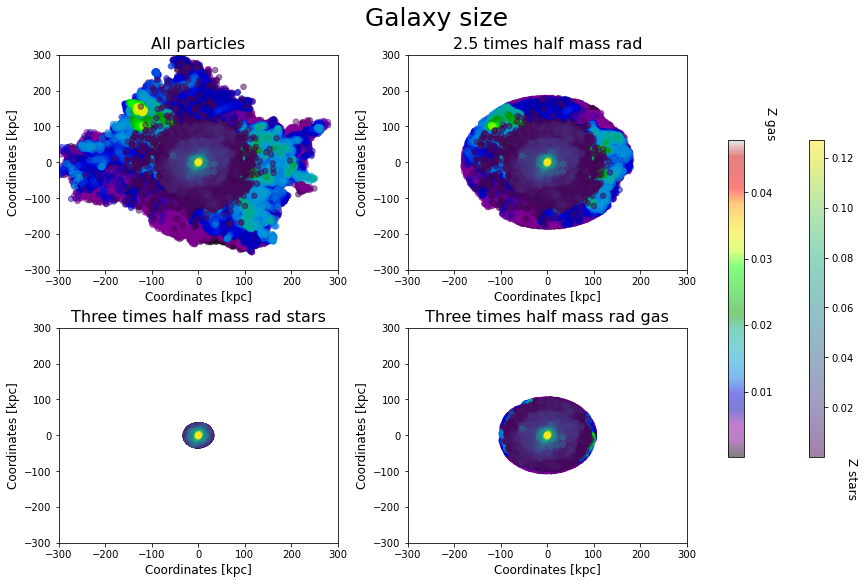

In [5]:
name    = np.array([['All particles','2.5 times half mass rad'],
                    ['Three times half mass rad stars','Three times half mass rad gas']])
x       = np.array([[stars['r'][:,0],halfmassrad[:,0]],[halfmassrad_stars[:,0],halfmassrad_gas[:,0]]],
                   dtype=object)
x_g     = np.array([[gas['r'][:,0],halfmassrad_g[:,0]],[halfmassrad_stars_g[:,0],halfmassrad_gas_g[:,0]]],
                   dtype=object)
y       = np.array([[stars['r'][:,1],halfmassrad[:,1]],[halfmassrad_stars[:,1],halfmassrad_gas[:,1]]], 
                   dtype=object)
y_g     = np.array([[gas['r'][:,1],halfmassrad_g[:,1]],[halfmassrad_stars_g[:,1],halfmassrad_gas_g[:,1]]], 
                   dtype=object)
mass    = np.array([[stars['m'],stars['m'][r1]],[stars['m'][r2],stars['m'][r3]]], dtype=object)
mass_g  = np.array([[gas['m'],gas['m'][r4]],[gas['m'][r5],gas['m'][r6]]], dtype=object)
z_met   = np.array([[stars['Z'],stars['Z'][r1]],[stars['Z'][r2],stars['Z'][r3]]], dtype=object)
z_met_g = np.array([[gas['Z'],gas['Z'][r4]],[gas['Z'][r5],gas['Z'][r6]]], dtype=object)

fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')
for col in range(2):
    for row in range(2):
        ax = axs[row, col]
        idx = z_met[row, col].argsort()
        idy = z_met_g[row, col].argsort()
        bax = ax.scatter(x_g[row, col][idy], y_g[row, col][idy], c=z_met_g[row, col][idy], s=30, alpha=0.5,
                         cmap='nipy_spectral')
        cax = ax.scatter(x[row, col][idx], y[row, col][idx], c=z_met[row, col][idx], s=30, alpha=0.5,
                         cmap='viridis')
        ax.set_xlabel('Coordinates [kpc]',fontsize=12)
        ax.set_ylabel('Coordinates [kpc]',fontsize=12)
        ax.set_title(name[row, col],fontsize=16)
        ax.set_xlim((-300, 300))
        ax.set_ylim((-300, 300))
cbar = fig.colorbar(cax, ax=axs, location='right', shrink=0.65)
cbar.set_label('Z stars', rotation=270,loc='bottom',fontsize=12)
bbar = fig.colorbar(bax, ax=axs, location='right', shrink=0.65)
bbar.set_label('Z gas', rotation=270, loc='top',fontsize=12)
fig.suptitle('Galaxy size',fontsize=25)